## Etapa 1: Problema

#### A partir de um conjunto de dados coletados do Censo de 1994 nos EUA, implementar um modelo que prevê se um indivíduo ganha mais de US \$ 50000 por ano.  

## Etapa 2: Checagem e limpeza de dados

#### Inicialmente vamos ler o conjunto de dados através de um DataFrame do pandas

In [32]:
import numpy as np
import pandas as pd

seed = 7
np.random.seed(seed)

data = pd.read_csv('census.csv')
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [33]:
num_samples = data.shape[0]
num_samples

5533

In [34]:
data.describe().astype(int)

,age,education-num,capital-gain,capital-loss,hours-per-week
count,5533,5533,5532,5532,5532
mean,38,10,1065,92,41
std,13,2,7251,409,11
min,17,1,0,0,1
25%,28,9,0,0,40
50%,37,10,0,0,40
75%,47,13,0,0,45
max,90,16,99999,2824,99


#### Como se pode observar, o número de amostras do conjunto de dados é 5533 e na contagem de dados das variáveis contínuas do *dataset* temos um valor faltante para as variáveis *capital-gain*, *capital-loss* e *hours-per-week*.

#### Dessa forma, vamos verificar quais amostras do *dataset* apresentam valores faltantes.

In [35]:
data.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       1
capital-loss       1
hours-per-week     1
native-country     1
income             1
dtype: int64

#### Além das variáveis contínuas mencionadas, temos valores faltantes nas variáveis categóricas *native-country* e *income*. 

#### Vamos checar em quantas instâncias temos valores faltantes:

In [36]:
num_na_rows = data.shape[0] - data.dropna().shape[0]
num_na_rows

1

#### Como só há uma instância com valor faltante, decidimos ignorá-la.

In [37]:
# Elimina linha com valores faltantes
data = data.dropna()
data.tail()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5527,57,Self-emp-not-inc,10th,6.0,Divorced,Exec-managerial,Own-child,White,Male,0.0,0.0,60.0,United-States,>50K
5528,47,Private,Some-college,10.0,Widowed,Other-service,Not-in-family,White,Female,0.0,0.0,35.0,United-States,<=50K
5529,51,Local-gov,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,Black,Male,0.0,0.0,60.0,United-States,<=50K
5530,34,Private,HS-grad,9.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
5531,52,Private,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


#### Antes de tudo, vamos visualizar os dados a fim de identificar possíveis *outliers* e erros

In [38]:
# Para mostrar plots da biblioteca matplotlib no notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="ticks", color_codes=True)

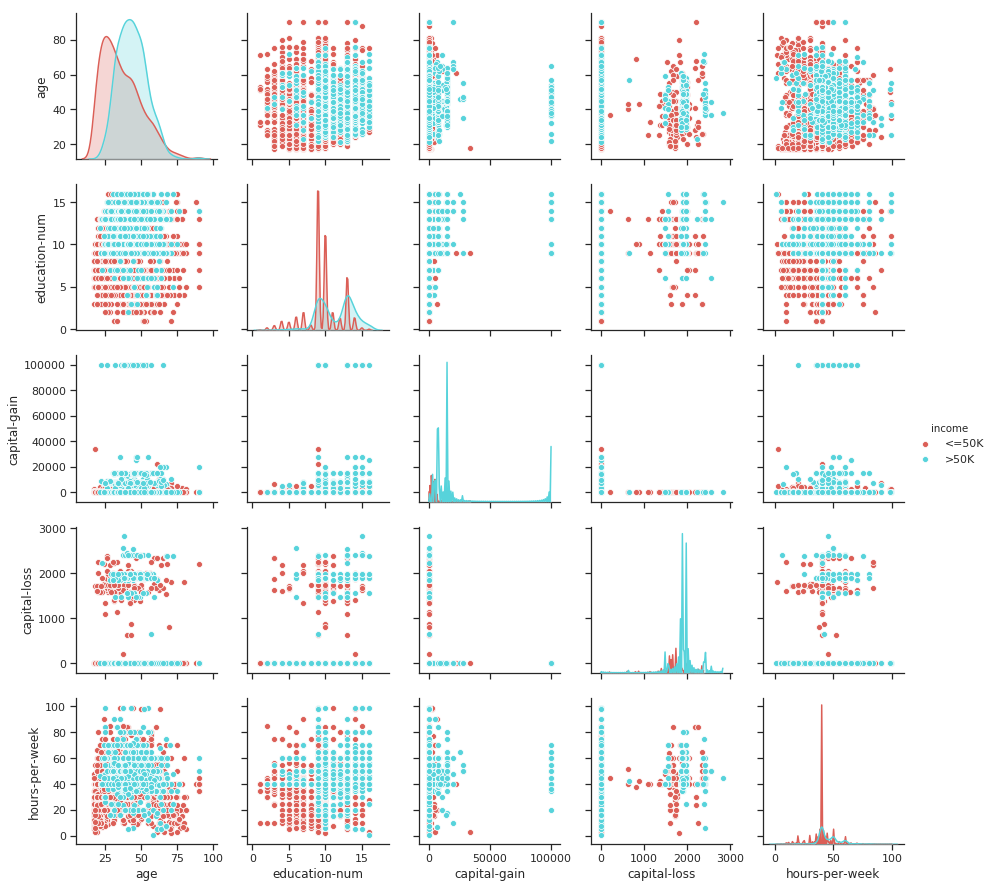

In [39]:
sb.pairplot(data, hue='income', palette='hls')

#### Como se pode observar no *pairplot* das variáveis contínuas, *capital-gain* e *capital-loss* apresentam distribuições enviesadas (pouca variância, dificultando a separação entre as duas classes desejadas).

#### Para evitar os *outliers* vamos usar uma transformação logarítmica

In [40]:
# Log(x+1), pois existem amostras de valor zero e não existe log de zero.
data[['capital-gain', 'capital-loss']] = data[['capital-gain', 'capital-loss']].apply(lambda x: np.log(x+1))

#### Reanalisando o gráfico de *pairplot*, temos:

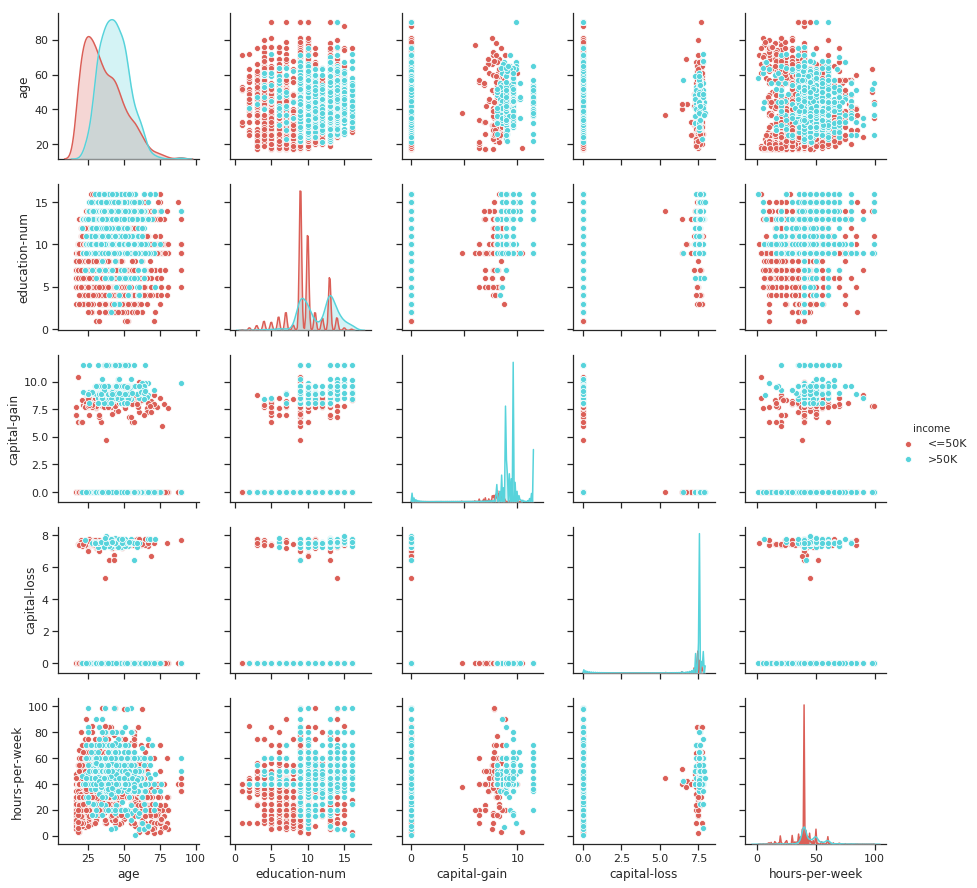

In [41]:
sb.pairplot(data, hue='income', palette='hls')

#### Agora vamos normalizar as variáveis numéricas de modo que fiquem no intervalo [0, 1] e dessa forma todos os dados de entrada estaram na mesma escala (alguns algoritmos de *Machine Learning* são variantes à escala).

#### A equação de normalização aplicada nas variáveis numéricas é dada por:
 
$$\ x_{scaled}=\frac{X - X_{min}}{X_{max} - X_{min}}$$

#### Visto que a variável *occupation* é irregular e pode atrapalhar na classificação, uma vez que não segue valores padronizados, será ignorada.
#### Como para cada valor de *education_level* temos um valor correspondente em *education-num*, essas informações são redundantes e, por isso, vamos ignorar a coluna categórica *education_level*.

In [42]:
# retira coluna occupation
data = data.drop('occupation',1)

# retira coluna education_level
data = data.drop('education_level',1)

In [43]:
data

,age,workclass,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13.0,Never-married,Not-in-family,White,Male,7.684784,0.000000,40.0,United-States,<=50K
1,50,Self-emp-not-inc,13.0,Married-civ-spouse,Husband,White,Male,0.000000,0.000000,13.0,United-States,<=50K
2,38,Private,9.0,Divorced,Not-in-family,White,Male,0.000000,0.000000,40.0,United-States,<=50K
3,53,Private,7.0,Married-civ-spouse,Husband,Black,Male,0.000000,0.000000,40.0,United-States,<=50K
4,28,Private,13.0,Married-civ-spouse,Wife,Black,Female,0.000000,0.000000,40.0,Cuba,<=50K
5,37,Private,14.0,Married-civ-spouse,Wife,White,Female,0.000000,0.000000,40.0,United-States,<=50K
6,49,Private,5.0,Married-spouse-absent,Not-in-family,Black,Female,0.000000,0.000000,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,9.0,Married-civ-spouse,Husband,White,Male,0.000000,0.000000,45.0,United-States,>50K
8,31,Private,14.0,Never-married,Not-in-family,White,Female,9.552866,0.000000,50.0,United-States,>50K
9,42,Private,13.0,Married-civ-spouse,Husband,White,Male,8.552367,0.000000,40.0,United-States,>50K


In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Colunas numéricas
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [45]:
data

,age,workclass,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,State-gov,0.800000,Never-married,Not-in-family,White,Male,0.667492,0.000000,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.800000,Married-civ-spouse,Husband,White,Male,0.000000,0.000000,0.122449,United-States,<=50K
2,0.287671,Private,0.533333,Divorced,Not-in-family,White,Male,0.000000,0.000000,0.397959,United-States,<=50K
3,0.493151,Private,0.400000,Married-civ-spouse,Husband,Black,Male,0.000000,0.000000,0.397959,United-States,<=50K
4,0.150685,Private,0.800000,Married-civ-spouse,Wife,Black,Female,0.000000,0.000000,0.397959,Cuba,<=50K
5,0.273973,Private,0.866667,Married-civ-spouse,Wife,White,Female,0.000000,0.000000,0.397959,United-States,<=50K
6,0.438356,Private,0.266667,Married-spouse-absent,Not-in-family,Black,Female,0.000000,0.000000,0.153061,Jamaica,<=50K
7,0.479452,Self-emp-not-inc,0.533333,Married-civ-spouse,Husband,White,Male,0.000000,0.000000,0.448980,United-States,>50K
8,0.191781,Private,0.866667,Never-married,Not-in-family,White,Female,0.829751,0.000000,0.500000,United-States,>50K
9,0.342466,Private,0.800000,Married-civ-spouse,Husband,White,Male,0.742849,0.000000,0.397959,United-States,>50K


In [46]:
# Separar features e labels
labels = data['income']
features = data.drop('income', axis = 1)

In [47]:
labels

0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
5       <=50K
6       <=50K
7        >50K
8        >50K
9        >50K
10       >50K
11       >50K
12      <=50K
13      <=50K
14      <=50K
15      <=50K
16      <=50K
17      <=50K
18       >50K
19       >50K
20      <=50K
21      <=50K
22      <=50K
23      <=50K
24       >50K
25      <=50K
26      <=50K
27      <=50K
28      <=50K
29      <=50K
        ...  
5502    <=50K
5503    <=50K
5504    <=50K
5505    <=50K
5506     >50K
5507    <=50K
5508    <=50K
5509    <=50K
5510    <=50K
5511     >50K
5512    <=50K
5513     >50K
5514    <=50K
5515     >50K
5516     >50K
5517    <=50K
5518     >50K
5519     >50K
5520    <=50K
5521    <=50K
5522    <=50K
5523     >50K
5524     >50K
5525    <=50K
5526    <=50K
5527     >50K
5528    <=50K
5529    <=50K
5530    <=50K
5531     >50K
Name: income, Length: 5532, dtype: object

#### Transformar labels de string para números:

In [48]:
labels = labels.replace({'<=50K':0, '>50K':1})

In [49]:
categorical_columns = features.select_dtypes(include=[object]).columns.tolist()

In [50]:
categorical_columns

['workclass',
 'marital-status',
 'relationship',
 'race',
 'sex',
 'native-country']

#### Codificar também as variáveis categóricas usando *Binary Encoding* :

In [51]:
import category_encoders as ce

binary_encoder_features = features.copy()

# binary encoder
encoder_binary = ce.BinaryEncoder(cols=categorical_columns)
df_binary = encoder_binary.fit_transform(binary_encoder_features)
#df_binary = pd.get_dummies(binary_encoder_features)

In [52]:
df_binary

,workclass_0,workclass_1,workclass_2,workclass_3,marital-status_0,marital-status_1,marital-status_2,marital-status_3,relationship_0,relationship_1,...,native-country_2,native-country_3,native-country_4,native-country_5,native-country_6,age,education-num,capital-gain,capital-loss,hours-per-week
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0.301370,0.800000,0.667492,0.000000,0.397959
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0.452055,0.800000,0.000000,0.000000,0.122449
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,0,1,0.287671,0.533333,0.000000,0.000000,0.397959
3,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0.493151,0.400000,0.000000,0.000000,0.397959
4,0,0,1,1,0,0,1,0,0,0,...,0,0,0,1,0,0.150685,0.800000,0.000000,0.000000,0.397959
5,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0.273973,0.866667,0.000000,0.000000,0.397959
6,0,0,1,1,0,1,0,0,0,0,...,0,0,0,1,1,0.438356,0.266667,0.000000,0.000000,0.153061
7,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0.479452,0.533333,0.000000,0.000000,0.448980
8,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0.191781,0.866667,0.829751,0.000000,0.500000
9,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0.342466,0.800000,0.742849,0.000000,0.397959


In [53]:
num_features_binary = df_binary.shape[1]

In [54]:
num_features_binary

30

In [55]:
new_data = df_binary.join(labels)

In [56]:
new_data

,workclass_0,workclass_1,workclass_2,workclass_3,marital-status_0,marital-status_1,marital-status_2,marital-status_3,relationship_0,relationship_1,...,native-country_3,native-country_4,native-country_5,native-country_6,age,education-num,capital-gain,capital-loss,hours-per-week,income
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0.301370,0.800000,0.667492,0.000000,0.397959,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0.452055,0.800000,0.000000,0.000000,0.122449,0
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0.287671,0.533333,0.000000,0.000000,0.397959,0
3,0,0,1,1,0,0,1,0,0,0,...,0,0,0,1,0.493151,0.400000,0.000000,0.000000,0.397959,0
4,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0.150685,0.800000,0.000000,0.000000,0.397959,0
5,0,0,1,1,0,0,1,0,0,0,...,0,0,0,1,0.273973,0.866667,0.000000,0.000000,0.397959,0
6,0,0,1,1,0,1,0,0,0,0,...,0,0,1,1,0.438356,0.266667,0.000000,0.000000,0.153061,0
7,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0.479452,0.533333,0.000000,0.000000,0.448980,1
8,0,0,1,1,0,0,0,1,0,0,...,0,0,0,1,0.191781,0.866667,0.829751,0.000000,0.500000,1
9,0,0,1,1,0,0,1,0,0,0,...,0,0,0,1,0.342466,0.800000,0.742849,0.000000,0.397959,1


In [57]:
new_data.to_csv('census-clean.csv', index=False)

## Etapa 3: Modelagem (Testar)

In [58]:
data_clean = pd.read_csv('census-clean.csv')

In [59]:
# Preparando dados de treinamento e labels
columns = data_clean.columns.tolist()
inputs = data_clean[columns[:-1]].values
labels = data_clean['income'].values

In [60]:
# separar dados de treino e teste
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(inputs, labels, test_size=0.25, random_state=1)

In [61]:
# Classificador Árvore de Decisão
decision_tree_classifier = DecisionTreeClassifier()

# Treinamento
decision_tree_classifier.fit(training_inputs, training_classes)

# Acurácia nos dados de teste
decision_tree_classifier.score(testing_inputs, testing_classes)

0.789587852494577

#### Realizar Cross-Validation para verificaro quão bem o modelo pode generalizar e, ao mesmo tempo, fazendo um *tuning* de parâmetros do modelo como *Grid Search*

#### Decision Tree

In [62]:
decision_tree_classifier = DecisionTreeClassifier()

# Grid de busca
parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

# Cross-validation com k = 10 folds
cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7924801156905278
Best parameters: {'max_depth': 5, 'max_features': 4}


In [63]:
y_true, y_pred = testing_classes, grid_search.predict(testing_inputs)
log_loss(y_true, y_pred)

6.2934360275890056

In [64]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### Random Forest

In [65]:
random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.8298385153048927
Best parameters: {'max_features': 4, 'n_estimators': 25, 'criterion': 'entropy'}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
y_true, y_pred = testing_classes, grid_search.predict(testing_inputs)
log_loss(y_true, y_pred)

5.644136100219171

#### SVM - Support Vector Machine

In [71]:
svm = SVC()

parameter_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.8262231863099542
Best parameters: {'C': 100, 'kernel': 'linear'}


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
y_true, y_pred = testing_classes, grid_search.predict(testing_inputs)
log_loss(y_true, y_pred)

5.893867241780953